In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.metrics import f1_score, classification_report
from matplotlib import pyplot as plt

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy

class SugenoDepressionAnalyzer:
    def __init__(self, file_path):
        """Инициализация анализатора с загрузкой данных"""
        self.data = pd.read_csv(file_path, index_col='id')
        self.data = self.data.dropna()
        self.weights = {}
        self.features = [
            'Academic Pressure',
            'Work Pressure',
            'Sleep Duration',
            'Financial Stress',
            'Family History of Mental Illness',
            'Have you ever had suicidal thoughts ?',
            'CGPA',  # Добавлен новый признак
            'Work/Study Hours'  # Добавлен новый признак
        ]
        
    def _preprocess_data(self):
        """Нормализация и преобразование данных"""
        # Бинарное кодирование
        self.data['Family History of Mental Illness'] = self.data['Family History of Mental Illness'].map(
            {'Yes': 1, 'No': 0})
        self.data['Have you ever had suicidal thoughts ?'] = self.data['Have you ever had suicidal thoughts ?'].map(
            {'Yes': 1, 'No': 0})
        
        # Преобразование категориальных данных о сне
        sleep_map = {
            'Less than 5 hours': 0.2,
            '5-6 hours': 0.5,
            '6-7 hours': 0.8,
            'More than 7 hours': 1
        }
        self.data['Sleep Duration'] = self.data['Sleep Duration'].map(sleep_map)
        
        # Нормализация числовых признаков
        scaler = MinMaxScaler()
        numeric_features = ['Academic Pressure', 'Work Pressure', 'Financial Stress', 'CGPA', 'Work/Study Hours']
        self.data[numeric_features] = scaler.fit_transform(self.data[numeric_features])
        
        # Инвертируем CGPA (чем выше CGPA, тем ниже риск депрессии)
        self.data['CGPA'] = 1 - self.data['CGPA']
        
    def _calculate_weights(self):
        """Автоматический расчет весов на основе энтропии"""
        normalized = self.data[self.features].apply(lambda x: x/x.sum(), axis=0)
        k = 1/np.log(len(self.data))
        e_j = normalized.apply(lambda x: -k*(x*np.log(x)).sum())
        d_j = 1 - e_j
        self.weights = {feature: weight for feature, weight in zip(self.features, d_j/d_j.sum())}
        
        # Ручная корректировка весов для новых признаков
        self.weights['CGPA'] *= 0.7  # Умеренное влияние
        self.weights['Work/Study Hours'] *= 0.6  # Среднее влияние
        
        # Нормализуем веса, чтобы сумма была равна 1
        total_weight = sum(self.weights.values())
        self.weights = {k: v/total_weight for k, v in self.weights.items()}

    def _sugeno_integral(self, row):
        """Вычисление интеграла Сугено для одной записи"""
        sorted_scores = sorted([(f, row[f]) for f in self.features], key=lambda x: x[1])
        cumulative_weight = 0
        sugeno_values = []
        
        for feature, score in sorted_scores:
            cumulative_weight += self.weights[feature]
            sugeno_values.append(min(score, cumulative_weight))
            
        return max(sugeno_values)
    
    def analyze(self):
        """Основной рабочий процесс"""
        self._preprocess_data()
        self._calculate_weights()
        
        print("Рассчитанные веса критериев:")
        for feature, weight in self.weights.items():
            print(f"{feature}: {weight:.3f}")
        
        self.data['Sugeno_Score'] = self.data.apply(self._sugeno_integral, axis=1)
        self.ranked_data = self.data.sort_values('Sugeno_Score', ascending=False)
        
        self._visualize_results()
        self._statistical_analysis()
    
    def _visualize_results(self):
        """Графическое представление результатов"""
        plt.figure(figsize=(16, 12))
        
        # Распределение оценок
        plt.subplot(2, 2, 1)
        plt.hist(self.data['Sugeno_Score'], bins=20, color='skyblue', edgecolor='black')
        plt.title('Распределение оценок депрессии', fontsize=12)
        plt.xlabel('Sugeno Score')
        plt.ylabel('Количество студентов')
        
        # Матрица корреляций
        plt.subplot(2, 2, 2)
        corr_matrix = self.data[self.features + ['Sugeno_Score']].corr()
        plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        plt.colorbar()
        #plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
        plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
        plt.title('Матрица корреляций', fontsize=12)
        
        # Влияние факторов
        plt.subplot(2, 2, 3)
        feature_impacts = self.data[self.features].mean() * pd.Series(self.weights)
        feature_impacts.sort_values().plot(kind='barh', color='teal')
        plt.title('Вклад факторов в оценку депрессии', fontsize=12)
        plt.xlabel('Взвешенное влияние')
        
        plt.tight_layout()
        plt.show()
        
    def _statistical_analysis(self):
        """Анализ статистических показателей"""
        print("\nСтатистика по оценкам:")
        print(self.data['Sugeno_Score'].describe())
        
        if 'Depression' in self.data.columns:
            correlation = self.data[['Sugeno_Score', 'Depression']].corr().iloc[0,1]
            print(f"\nКорреляция с исходными данными: {correlation:.3f}")
            
            # Анализ точности прогноза
            threshold = 0.5
            predicted = (self.data['Sugeno_Score'] > threshold).astype(int)
            actual = self.data['Depression']
            accuracy = (predicted == actual).mean()
            print(f"\nТочность прогноза (при threshold={threshold}): {accuracy:.2%}")
            
        high_risk = self.data[self.data['Sugeno_Score'] > 0.7]
        print(f"\nСтудентов с высоким риском: {len(high_risk)}")
        print("Распределение по полу:")
        print(high_risk['Gender'].value_counts())
        
    def get_high_risk_students(self, threshold=0.7):
        """Получение списка студентов группы риска"""
        return self.ranked_data[self.ranked_data['Sugeno_Score'] > threshold][
            ['Gender', 'Age', 'Sugeno_Score', 'CGPA', 'Work/Study Hours', 'Depression'] + self.features]
        
    def get_all_students(self):
        return self.ranked_data[['Gender', 'Age', 'Sugeno_Score', 'Depression']]

C:\Users\aerty\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Рассчитанные веса критериев:
Academic Pressure: 0.009
Work Pressure: 0.779
Sleep Duration: 0.064
Financial Stress: 0.026
Family History of Mental Illness: 0.061
Have you ever had suicidal thoughts ?: 0.039
CGPA: 0.014
Work/Study Hours: 0.009


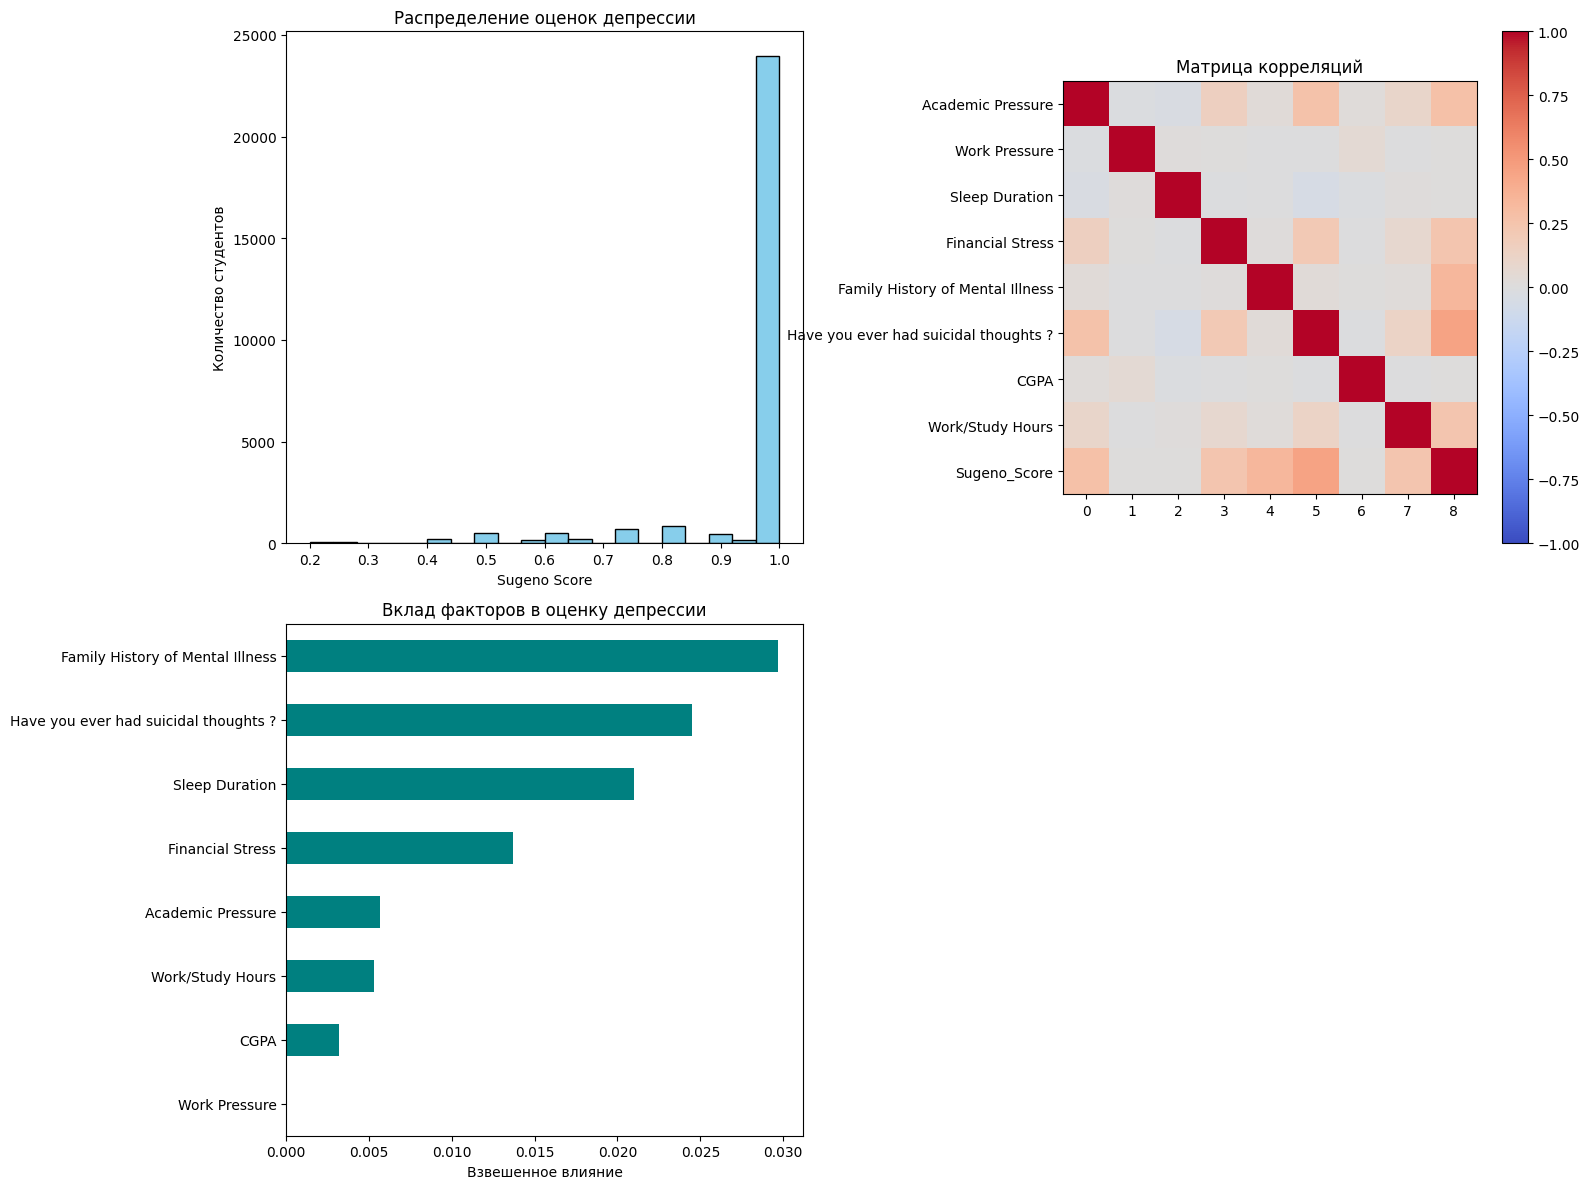


Статистика по оценкам:
count    27898.000000
mean         0.956257
std          0.126879
min          0.200000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Sugeno_Score, dtype: float64

Корреляция с исходными данными: 0.347

Точность прогноза (при threshold=0.5): 61.59%

Студентов с высоким риском: 26139
Распределение по полу:
Gender
Male      14509
Female    11630
Name: count, dtype: int64

Список студентов с высоким риском:


,Gender,Age,Sugeno_Score,CGPA,Work/Study Hours,Depression,Academic Pressure,Work Pressure,Sleep Duration,Financial Stress,Family History of Mental Illness,Have you ever had suicidal thoughts ?,CGPA,Work/Study Hours
id,,,,,,,,,,,,,,
2,Male,33.0,1.0,0.103,0.250000,1,1.0,0.0,0.5,0.00,0,1,0.103,0.250000
90489,Female,33.0,1.0,0.130,0.333333,0,0.6,0.0,0.5,1.00,0,0,0.130,0.333333
90537,Female,23.0,1.0,0.156,0.166667,0,0.4,0.0,NaN,0.00,1,1,0.156,0.166667
90533,Male,33.0,1.0,0.034,0.166667,0,0.8,0.0,NaN,0.00,0,1,0.034,0.166667
90529,Female,25.0,1.0,0.193,0.333333,0,0.8,0.0,NaN,1.00,0,1,0.193,0.333333
90528,Male,28.0,1.0,0.067,0.666667,0,0.6,0.0,0.5,0.75,1,1,0.067,0.666667
90519,Male,33.0,1.0,0.317,0.833333,0,0.6,0.0,0.2,0.00,1,1,0.317,0.833333
90518,Male,19.0,1.0,0.136,0.583333,1,0.4,0.0,0.2,1.00,0,1,0.136,0.583333
90510,Female,21.0,1.0,0.005,0.916667,1,0.6,0.0,NaN,1.00,0,1,0.005,0.916667


In [152]:
analyzer = SugenoDepressionAnalyzer('Student Depression Dataset.csv')
analyzer.analyze()

# Получение и вывод студентов группы риска
high_risk = analyzer.get_high_risk_students()
print("\nСписок студентов с высоким риском:")
high_risk.head(10)

In [135]:
high_risk.describe()

,Age,Sugeno_Score,CGPA,Work/Study Hours,Depression,Academic Pressure,Work Pressure,Sleep Duration,Financial Stress,Family History of Mental Illness,Have you ever had suicidal thoughts ?,CGPA,Work/Study Hours
count,26139.000000,26139.000000,26139.000000,26139.000000,26139.000000,26139.000000,26139.000000,13629.000000,26139.000000,26139.000000,26139.000000,26139.000000,26139.000000
mean,25.753472,0.985536,0.234229,0.614121,0.621179,0.644776,0.000092,0.327889,0.555798,0.516508,0.675466,0.234229,0.614121
std,4.892952,0.051916,0.146941,0.305570,0.485103,0.274283,0.009090,0.148367,0.358136,0.499737,0.468210,0.146941,0.305570
min,18.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,1.000000,0.108000,0.333333,0.000000,0.400000,0.000000,0.200000,0.250000,0.000000,0.000000,0.108000,0.333333
50%,25.000000,1.000000,0.223000,0.666667,1.000000,0.600000,0.000000,0.200000,0.500000,1.000000,1.000000,0.223000,0.666667
75%,30.000000,1.000000,0.371000,0.833333,1.000000,0.800000,0.000000,0.500000,1.000000,1.000000,1.000000,0.371000,0.833333
max,59.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000


In [136]:
studs = analyzer.get_all_students()

In [158]:
studs.describe()

,Age,Sugeno_Score,Depression
count,27898.000000,27898.000000,27898.000000
mean,25.822174,0.956257,0.585526
std,4.905651,0.126879,0.492640
min,18.000000,0.200000,0.000000
25%,21.000000,1.000000,0.000000
50%,25.000000,1.000000,1.000000
75%,30.000000,1.000000,1.000000
max,59.000000,1.000000,1.000000


In [138]:
X_train, X_test, y_train, y_test = train_test_split(studs.drop('Depression', axis=1), studs['Depression'], test_size=0.2, random_state=42)

In [159]:
def calculat_f1(threshold):
    preds = (X_train['Sugeno_Score'] > threshold[0]).astype(np.int32)
    return f1_score(y_train, preds)

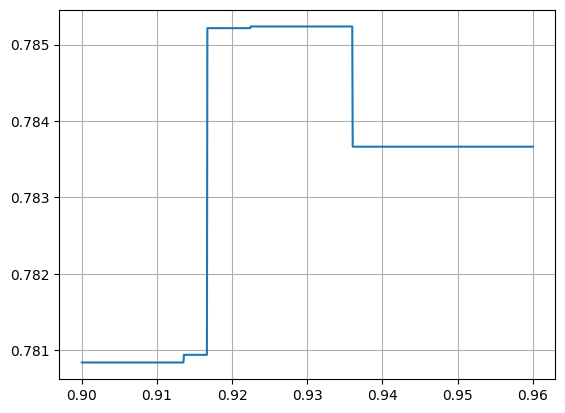

In [160]:
length = 1000

thresh_values = np.linspace(0.9, 0.96, length)[..., None]
f1_values = np.zeros(length)

for idx, thresh in enumerate(thresh_values):
    f1_values[idx] = calculat_f1(thresh)

plt.plot(thresh_values, f1_values)
plt.grid(True)

In [141]:
threshold = 0.93
y_pred_train = (X_train['Sugeno_Score'] > threshold).astype(np.int32)
y_pred_test = (X_test['Sugeno_Score'] > threshold).astype(np.int32)

In [142]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.88      0.29      0.43      9242
           1       0.66      0.97      0.79     13076

    accuracy                           0.69     22318
   macro avg       0.77      0.63      0.61     22318
weighted avg       0.75      0.69      0.64     22318



In [143]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.87      0.29      0.43      2321
           1       0.66      0.97      0.78      3259

    accuracy                           0.69      5580
   macro avg       0.76      0.63      0.61      5580
weighted avg       0.75      0.69      0.64      5580



In [156]:
analyzer.data.describe()

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Sugeno_Score
count,27898.000000,27898.000000,27898.000000,27898.000000,27898.000000,27898.000000,14490.000000,27898.000000,27898.000000,27898.000000,27898.000000,27898.000000,27898.000000
mean,25.822174,0.628267,0.000086,0.234384,2.943974,0.000681,0.327971,0.632877,0.596381,0.534967,0.483942,0.585526,0.956257
std,4.905651,0.276292,0.008799,0.147071,1.361122,0.044397,0.148379,0.482029,0.308967,0.359337,0.499751,0.492640,0.126879
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000
25%,21.000000,0.400000,0.000000,0.108000,2.000000,0.000000,0.200000,0.000000,0.333333,0.250000,0.000000,0.000000,1.000000
50%,25.000000,0.600000,0.000000,0.223000,3.000000,0.000000,0.200000,1.000000,0.666667,0.500000,0.000000,1.000000,1.000000
75%,30.000000,0.800000,0.000000,0.371000,4.000000,0.000000,0.500000,1.000000,0.833333,0.750000,1.000000,1.000000,1.000000
max,59.000000,1.000000,1.000000,1.000000,5.000000,4.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [155]:
data = pd.read_csv('Student Depression Dataset.csv', index_col='id')
data = data.dropna()
data

,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,
2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,Yes,0
140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,Yes,0
140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,No,0
